In [273]:
import numpy as np
import matplotlib.pyplot as plt
import lineid_plot
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.io import fits
from matplotlib.pyplot import figure
import astroscrappy




l_w = [3889.0, 4072.3, 4102.89, 4341.68, 4364.436, 4862.68, 
       4932.603, 4960.295, 5008.240, 6564.61, 6732.67]
l_l = ['He I', 'S II', 'He del','He ga','O III','H be',
       'O III','O III','O III','H alp','S II']

s_w = [5895.99, 5889.61, 5477.24, 5270.64, 5184.34, 5173.68, 5167.29, 4923.42, 4866.88, 4502.23, 
       4386.18, 4314.37, 3967.96, 3933.62]
s_l = ['Na I','Na I', 'Ni I', 'Fe I', 'Mg I', 'Mg I', 'Mg I', 'Fe II', 'H alp', 'Ti II', 'Fe I', 
       'Fe I', 'Ca II', 'Ca II']

### Read in data

In [232]:
hdul = fits.open('arcs.fits')
sci = fits.open('sci_test.fits')
solar = fits.open('solar spectrum.fits')
hdul[0].data.shape

(325, 2112)

In [237]:
spectrum2D = hdul[0].data[127:197]
spectrum1D = np.mean(spectrum2D,axis=0)

solar2D = solar[0].data[127:197]
solar1D = np.mean(solar2D,axis=0)

spectrum1D_list = list(spectrum1D)
list1 = list(spectrum1D)
list1.sort() 

### Enter Calibration points

In [225]:
# set up calibration points

length = len(list1) 
cali1 = spectrum1D_list.index(list1[length-1])
cali2 = spectrum1D_list.index(list1[length-2])
cali3 = spectrum1D_list.index(list1[length-5])
cali4 = spectrum1D_list.index(list1[length-9])
cali5 = spectrum1D_list.index(list1[length-11])
cali6 = spectrum1D_list.index(list1[length-22])

or1 = 4358.33
or2 = 5085.82
or3 = 4799.92
or4 = 4046.56
or5 = 4678.16
or6 = 3650.15

x = np.array([cali1, cali2, cali3, cali4, cali5, cali6])
y = np.array([or1, or2, or3, or4, or5, or6])
print(x)

[1241 1930 1664  932 1549  518]


### Linear transform function

In [226]:
# Linear fit function

def linfit(xdata, ydata, yerror):
    def U(n):
        U_n = sum((xdata**n)/(yerror**2), 0)
        return U_n
    def W(n): 
        W_n = sum(ydata * (xdata**n) / (yerror**2)) 
        return W_n
    D = U(0) * U(2) - (U(1)**2)
    slope = (U(0)*W(1) - U(1)*W(0)) / D
    intercept = (U(2)*W(0) - U(1)*W(1)) / D
    sigma_slope = U(0)/D
    sigma_intercept = U(2)/D
    return slope, intercept

In [227]:
# Fitting slope and intercept

slope = linfit(x,y,1)[0]
inter = linfit(x,y,1)[1]

### Apply transform to get wavelength vs. flux density

In [228]:
pixel = np.linspace(1,len(spectrum1D),len(spectrum1D))
cali = slope*pixel+inter

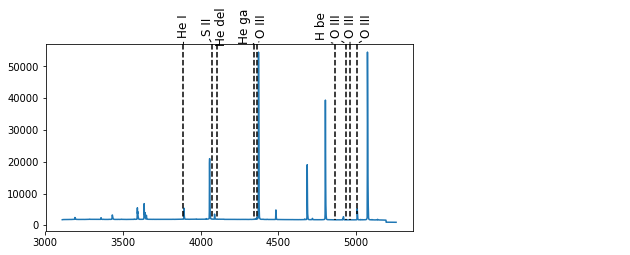

In [229]:
# spectrum with lines id

lineid_plot.plot_line_ids(cali,spectrum1D, l_w, l_l)
plt.show()

y= 1.0170929538622058 x+ 3108.50563324058


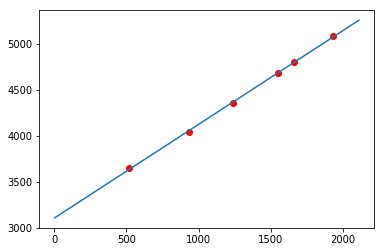

In [230]:
# Calibration linear fitting function

plt.plot(pixel,cali)
plt.scatter(x,y,c='r')
print("y=",slope,"x+",inter)

### Applying transform on smoothened solar spectrum

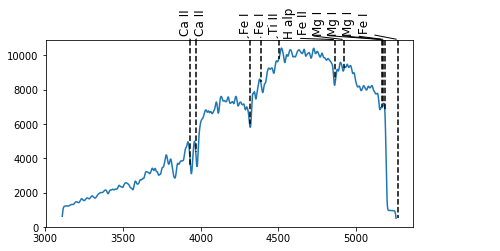

In [272]:
# Smoothed solar spectrum with absorption lines

gauss_kernel = Gaussian1DKernel(5)
smoothed_solar = convolve(solar1D, gauss_kernel)


lineid_plot.plot_line_ids(cali,smoothed_solar, s_w, s_l, figsize=(18,6))
plt.show()

In [286]:
whatever ,data_clean = astroscrappy.detect_cosmics(sci[0].data,inmask=None,cleantype='meanmask')

In [288]:
# test data
data_clean

array([[ 993.,  982.,  990., ...,  985.,  995.,  985.],
       [ 990.,  999., 1005., ...,  993.,  993.,  988.],
       [1063., 1070., 1056., ..., 1029., 1029., 1057.],
       ...,
       [1302., 1283., 1297., ..., 1317., 1325., 1366.],
       [1309., 1295., 1312., ..., 1302., 1304., 1363.],
       [1298., 1289., 1296., ..., 1307., 1318., 1351.]], dtype=float32)

### Cosmic ray removal

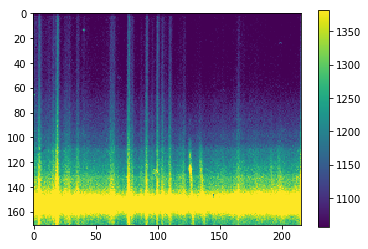

In [305]:
# After removing cosmic rays

plt.figure()
plt.imshow(data_clean, vmin = np.percentile(data_clean,16),vmax=np.percentile(data_clean,90))
plt.colorbar()

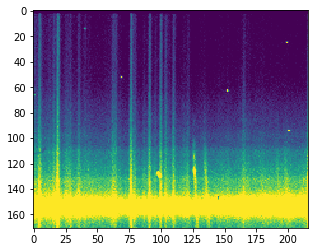

In [306]:
# Before removing cosmic rays(for comparison)

plt.figure()
plt.imshow(sci[0].data,vmin = np.percentile(sci[0].data,16),vmax=np.percentile(sci[0].data,90))

### Sky Subtraction and final image

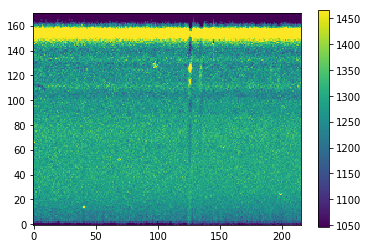

In [310]:
# image after reduce

xrows = np.arange(data_clean.shape[0])
bkg = np.zeros_like(data_clean)
x = np.arange(10,150)
for col in np.arange(data_clean.shape[1]):
    pfit = np.polyfit(x, data_clean[x, col], 2)
    bkg[:, col] = np.polyval(pfit,xrows)
    
plt.clf()
plt.imshow(bkg, origin='lower', vmin=np.percentile(bkg,5), vmax=np.percentile(bkg,95))
plt.colorbar()

reduced = data_clean - bkg

plt.imshow(reduced, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

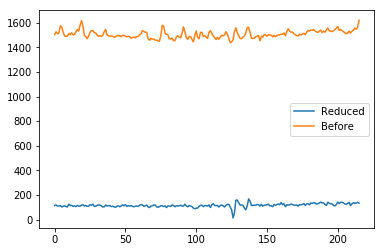

In [322]:
# comparison before & after sky-substraction

plt.plot(np.mean(reduced[145:155],axis=0),label='Reduced')
plt.plot(np.mean(data_clean[145:155],axis=0),label='Before')
plt.legend()